This notebook tests the run_epoch, eval_network and train_network functions in tools.py, which covers exercises 3 and 4.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torcheval.metrics

from sklearn.datasets import make_moons

import seaborn as sns

import time
import os
import sys
sys.path.append('..')
from tools import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

c:\Users\Miguel\miniconda3\envs\ml3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


<Axes: >

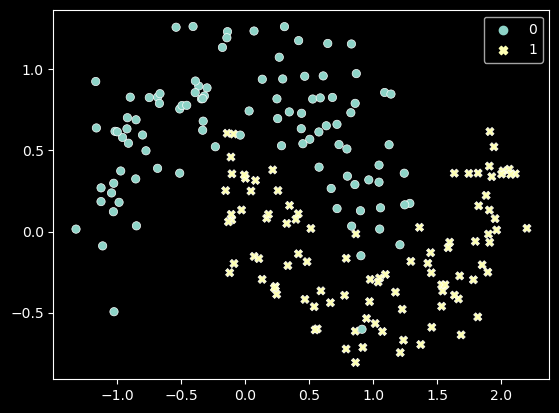

In [2]:
X_train, y_train = make_moons(n_samples=8000, noise=0.2)
X_test, y_test = make_moons(n_samples=200, noise=0.2)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, style=y_test)

In [3]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
# training_loader_256 = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
testing_loader_32 = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = torch.nn.functional.cross_entropy

In [4]:
y0_hat = model(train_dataset[:50][0].to(device))
y0 = train_dataset[:50][1].to(device)
print(y0_hat.shape)
print(y0.shape)

torch.Size([50, 2])
torch.Size([50])


In [5]:
#our classifier returns a [batch_len, n_classes] tensor of logits. but the
#torcheval metrics expect a [batch_len,] tensor of integer class labels, so we
#need to apply argmax along each row of the classifier output to get the
#predicted class
print(torcheval.metrics.functional.binary_accuracy( torch.argmax(y0_hat, axis=1) , y0))
print(torcheval.metrics.functional.binary_f1_score( torch.argmax(y0_hat, axis=1) , y0))

tensor(0.4000, device='cuda:0')
tensor(0.5714, device='cuda:0')


In [6]:
#to apply this preprocessing automatically to any metric functional, we pass the
#functional to the from_logits wrapper and use the wrapped functional
binary_accuracy_from_logits = from_logits(torcheval.metrics.functional.binary_accuracy)
binary_f1_from_logits = from_logits(torcheval.metrics.functional.binary_f1_score)
print(binary_accuracy_from_logits(y0_hat, y0))
print(binary_f1_from_logits(y0_hat, y0))

metrics = {"Loss": f_loss, "Accuracy": binary_accuracy_from_logits, "F1 Score": binary_f1_from_logits}
eval_loaders = {"Train": training_loader_32, "Test": testing_loader_32}

tensor(0.4000, device='cuda:0')
tensor(0.5714, device='cuda:0')


In [7]:
results = train_network( model, f_loss, optimizer, training_loader_32, eval_loaders=eval_loaders, eval_metrics=metrics, epochs=4, save_path=os.getcwd(), save_interval=2)
results

Epoch: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


,Last Epoch,Last Time,Train Loss,Train Accuracy,Train F1 Score,Test Loss,Test Accuracy,Test F1 Score
0,0,0.000000,0.775609,0.500000,0.666667,0.774169,0.500,0.666667
1,1,0.350612,0.283281,0.876875,0.876798,0.328847,0.860,0.862745
2,2,0.330031,0.274702,0.880500,0.881507,0.317115,0.865,0.868293
3,3,0.325580,0.256878,0.888750,0.889578,0.296350,0.865,0.868293
4,4,0.328619,0.217683,0.911000,0.911156,0.246153,0.905,0.906404


In [8]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer_new = torch.optim.AdamW(model_new.parameters())

In [9]:
results = train_network( model_new, f_loss, optimizer_new, training_loader_32, eval_loaders=eval_loaders, eval_metrics=metrics, epochs=2, save_path=os.getcwd(), load_file="checkpoint_epoch4.pt")
results

Epoch: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


,Last Epoch,Last Time,Train Loss,Train Accuracy,Train F1 Score,Test Loss,Test Accuracy,Test F1 Score
0,4,0.328619,0.217683,0.911000,0.911156,0.246153,0.905,0.906404
1,5,0.369042,0.157173,0.937625,0.938097,0.177435,0.930,0.932039
2,6,0.373383,0.116192,0.963500,0.963491,0.124387,0.965,0.965517
